In [2]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import seaborn as sns ###agregar a enviroment original
import pandas as pd


## Categorical Variable
So far our shp\geodataframe will have only categorical variables. 

columns=['DEPTYPE_D1','rock_class', 'belt']

In [3]:
# Load the deposit points
deposits = gpd.read_file(r"datasets\shp\cmBC.shp") #all critical minerals ocurrences in BC
#deposits_all = gpd.read_file(r"datasets\shp\cmBC.shp") # When selecting RS deposits

#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS') | (deposits_all['COMMOD_C3']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS')]

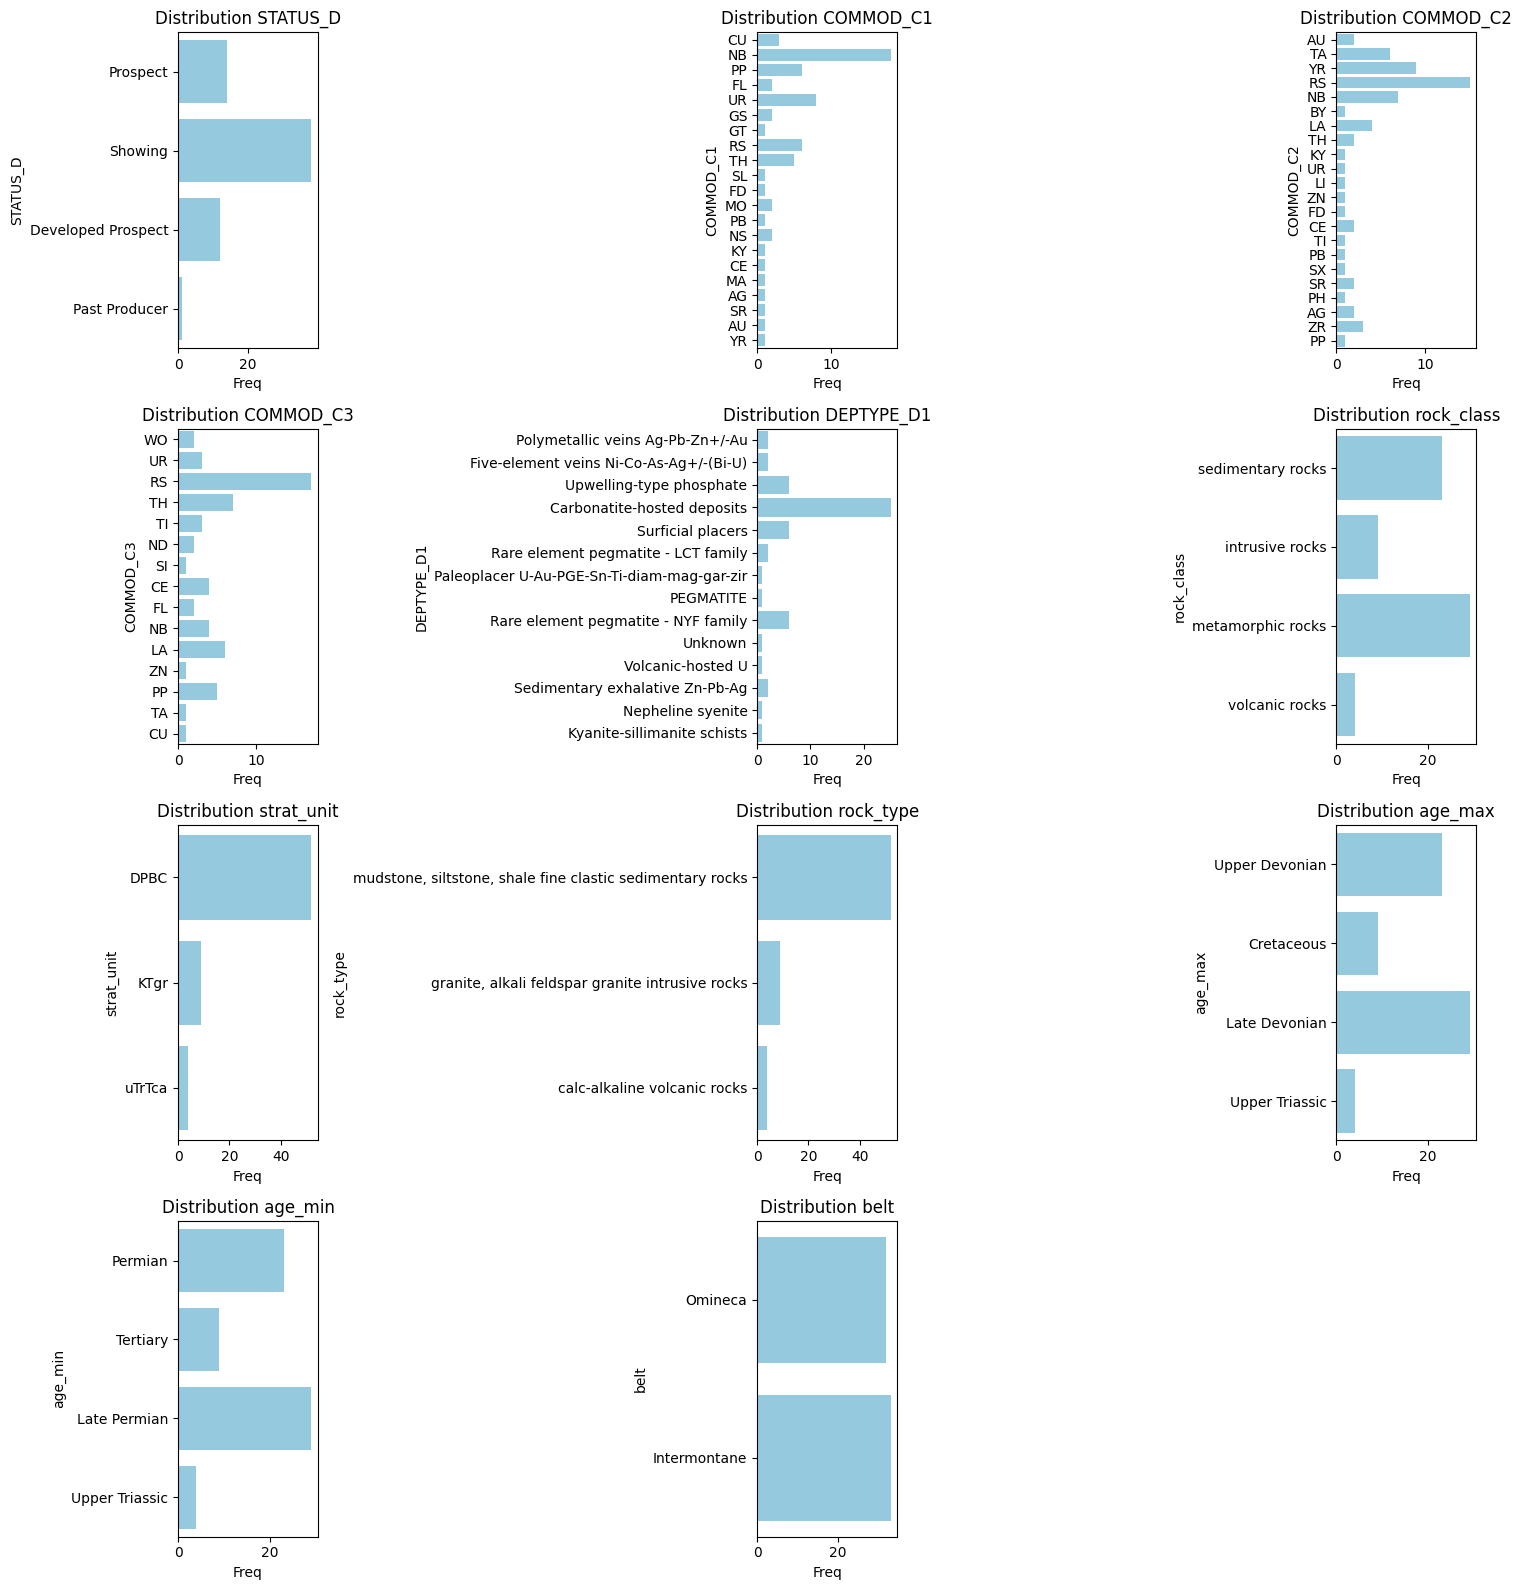

In [6]:
categorical_columns = deposits.select_dtypes(include=['object', 'category']).columns

n_cols = 3  # Número de columnas en la cuadrícula
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols #number of rows

# subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  # Ajustar el tamaño

#flatten the axis
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(y=col, data=deposits, ax=axes[i], color='skyblue')  # Usamos color en vez de palette
    axes[i].set_title(f'Distribution {col}', fontsize=12)
    axes[i].set_xlabel('Freq')
    axes[i].set_ylabel(col)

# delete empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


somehow decido solo quedarme con 3
columns=['DEPTYPE_D1','rock_class', 'belt']



In [8]:
deposits.drop(columns=['STATUS_D','strat_unit', 'rock_type', 'age_max', 'age_min'], inplace=True)

## Aligned rasters ## Pasarlo a datacleaning notebook

In [4]:
import rasterio

# Get the common extent (intersection) of all rasters
min_x, min_y, max_x, max_y = None, None, None, None

for raster_path in raster_paths:
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        if min_x is None:
            min_x, min_y, max_x, max_y = bounds.left, bounds.bottom, bounds.right, bounds.top
        else:
            min_x = max(min_x, bounds.left)
            min_y = max(min_y, bounds.bottom)
            max_x = min(max_x, bounds.right)
            max_y = min(max_y, bounds.top)

# Print the common extent
print(f"Common extent: min_x={min_x}, min_y={min_y}, max_x={max_x}, max_y={max_y}")


Common extent: min_x=273834.58394517144, min_y=369328.52570075076, max_x=1869862.2911765492, max_y=1735748.0045129722


In [6]:
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_bounds

def align_raster_to_common_extent(raster_path, common_extent, target_resolution):
    with rasterio.open(raster_path) as src:
        # Calculate the transform based on the common extent and target resolution
        min_x, min_y, max_x, max_y = common_extent
        width = int((max_x - min_x) / target_resolution)
        height = int((max_y - min_y) / target_resolution)
        transform = from_bounds(min_x, min_y, max_x, max_y, width, height)

        # Define new metadata with common extent and resolution
        meta = src.meta.copy()
        meta.update({
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'transform': transform,
            'crs': src.crs,
            'count': src.count
        })

        # Read and resample the raster data to the new extent and resolution
        data = src.read(
            out_shape=(src.count, height, width),
            resampling=Resampling.nearest
        )

        # Save the resampled raster
        resampled_raster_path = os.path.join("datasets/raster/aligned", f"aligned_{os.path.basename(raster_path)}")
        with rasterio.open(resampled_raster_path, "w", **meta) as dst:
            dst.write(data)
        
        print(f"Aligned and saved: {resampled_raster_path}")

# Apply the alignment to each raster
common_extent = (min_x, min_y, max_x, max_y)  # Use the extent you obtained earlier
target_resolution = 1000  # Your raster resolution
for raster_path in raster_paths:
    align_raster_to_common_extent(raster_path, common_extent, target_resolution)


Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - 1st Vertical Derivative_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Gravity Anomalies_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Horizontal Gradient_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Isostatic Residual_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Equivalent Thorium eTh - 2012 - Geotif_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Equivalent Uranium eU - 2012 - Geotif_float.tif
Aligned and saved: datasets/raster/aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - eTh-K - 2012 - Geotif_float.tif
Aligned and saved

## Numerical Variables
### PCA Analysis for points CM REE

In [10]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
#
# Load the deposit points
#deposits = gpd.read_file(r"datasets\shp\cmBC.shp") #all critical minerals ocurrences in BC
#deposits_all = gpd.read_file(r"datasets\shp\cmBC.shp") # When selecting RS deposits

#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS') | (deposits_all['COMMOD_C3']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS')]

# Define the raster files list
raster_paths = [os.path.join(r'datasets\raster\aligned', f) for f in os.listdir(r'datasets\raster\aligned') if f.lower().endswith('.tif')]


In [18]:
# Initialize an array to hold raster values for each deposit point
features = np.zeros((len(deposits), len(raster_paths)))

# Extract raster values at deposit locations
for i, raster_path in enumerate(raster_paths):
    with rasterio.open(raster_path) as src:
        # Use sample to extract raster values at points
        raster_values = [x[0] for x in src.sample([(point.x, point.y) for point in deposits.geometry])]
        features[:, i] = raster_values

features_df = pd.DataFrame(data=features, columns=[raster_path.split('/')[-1] for raster_path in raster_paths])
features_df.head()


,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - 1st Vertical Derivative_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Gravity Anomalies_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Horizontal Gradient_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Isostatic Residual_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Equivalent Thorium eTh - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Equivalent Uranium eU - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - eTh-K - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - eU-eTh - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - eU-K - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Potassium K - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif
0,199.0,0.0,248.0,167.0,181.379852,239.248047,255.0,255.0,255.0,21.412943,229.920990,142.107132
1,244.0,15.0,159.0,248.0,255.000000,255.000000,255.0,255.0,255.0,255.000000,2.997955,22.280083
2,6.0,0.0,239.0,228.0,255.000000,255.000000,255.0,255.0,255.0,255.000000,241.514847,242.756836
3,8.0,0.0,172.0,231.0,255.000000,255.000000,255.0,255.0,255.0,255.000000,230.572937,232.104263
4,247.0,0.0,166.0,245.0,255.000000,255.000000,255.0,255.0,255.0,255.000000,237.824356,240.413406


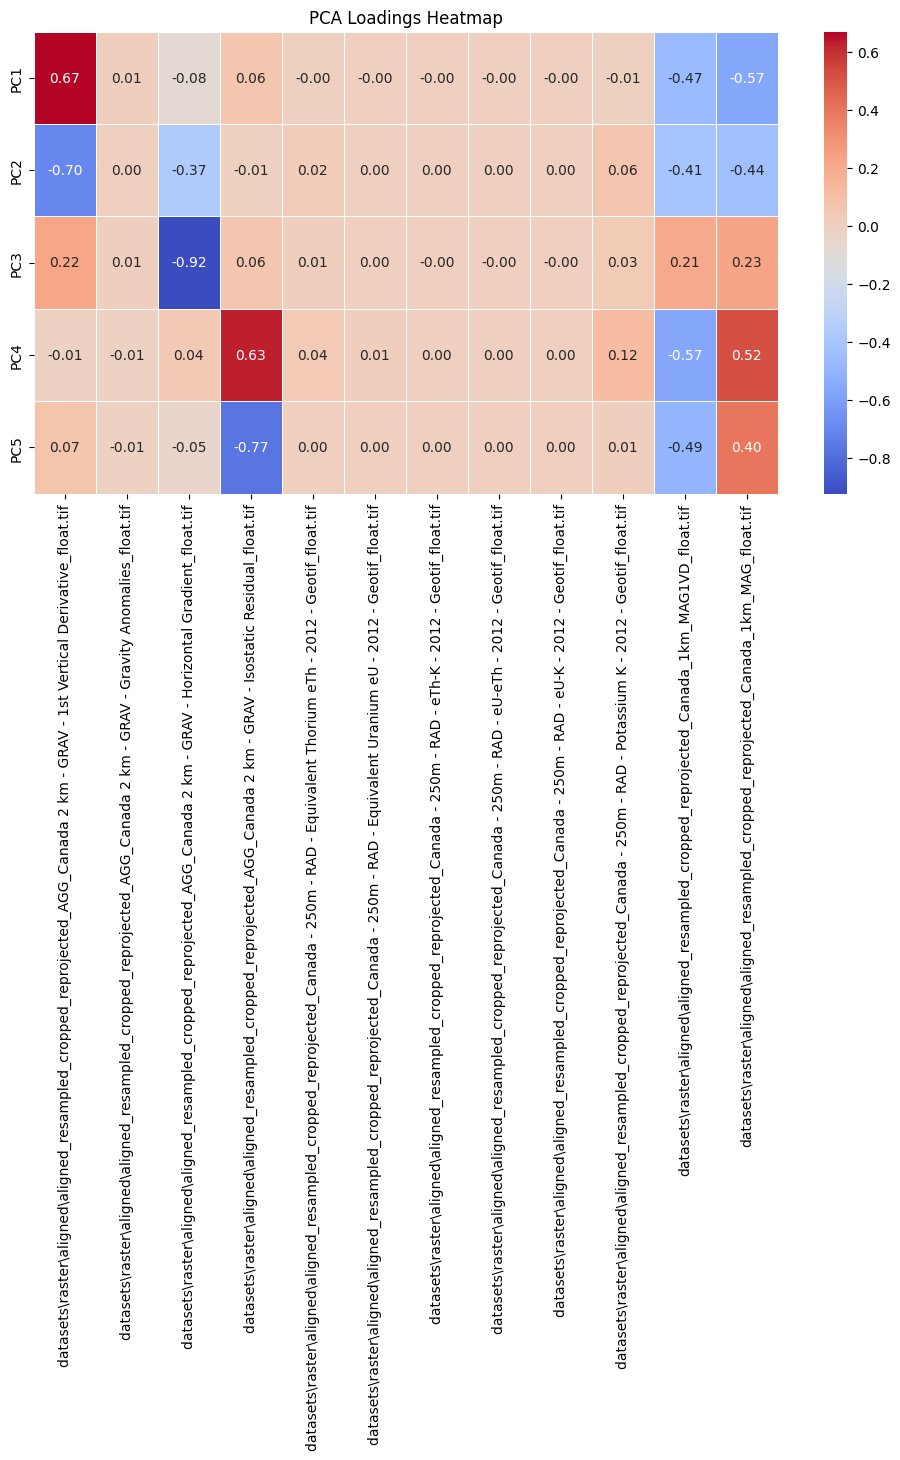

In [12]:
# Initialize PCA, let's reduce to 5 principal components for visualization
pca = PCA(n_components=5)

# Fit and transform the features
principal_components = pca.fit_transform(features)

# Convertir los coeficientes a un DataFrame para mejor visualización
loadings = pca.components_
loadings_df = pd.DataFrame(data=loadings, columns=features_df.columns, index=['PC1', 'PC2','PC3','PC4','PC5'])

plt.figure(figsize=(12, 6))  # Puedes ajustar el tamaño según tus necesidades
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('PCA Loadings Heatmap')
plt.show()

In [27]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component: {(100*explained_variance)}, which represent up to {round(sum(explained_variance)*100,2)}% of the total data")

Explained variance by component: [45.87147883 22.19716655 14.72686533  8.0888368   6.45367847], which represent up to 97.34% of the total data


We can be confident that with all the rasters, except for the RAD ones, we can achieve a high level of explained variance and reduce dimensionality. Although the contribution of K is small, it will still be included in the results

In [37]:
columns = [i for i in features_df.columns if 'RAD' in i and 'Potassium' not in i]
columns
features_important=features_df.drop(columns=columns)


# Join this DataFrame with the deposits DataFrame to keep geographic info
final_df = pd.concat([deposits.reset_index(drop=True), features_important], axis=1)
final_df

,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,rock_class,belt,geometry,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - 1st Vertical Derivative_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Gravity Anomalies_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Horizontal Gradient_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Isostatic Residual_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - Potassium K - 2012 - Geotif_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif
0,CU,AU,WO,Polymetallic veins Ag-Pb-Zn+/-Au,sedimentary rocks,Omineca,POINT (1712345.013 508793.306),199.0,0.0,248.0,167.0,21.412943,229.920990,142.107132
1,NB,TA,UR,Five-element veins Ni-Co-As-Ag+/-(Bi-U),intrusive rocks,Omineca,POINT (1608464.203 529884.983),244.0,15.0,159.0,248.0,255.000000,2.997955,22.280083
2,PP,YR,RS,Upwelling-type phosphate,sedimentary rocks,Omineca,POINT (1830188.498 519602.589),6.0,0.0,239.0,228.0,255.000000,241.514847,242.756836
3,PP,YR,RS,Upwelling-type phosphate,sedimentary rocks,Omineca,POINT (1824029.824 520918.724),8.0,0.0,172.0,231.0,255.000000,230.572937,232.104263
4,PP,YR,RS,Upwelling-type phosphate,sedimentary rocks,Omineca,POINT (1816570.908 525002.475),247.0,0.0,166.0,245.0,255.000000,237.824356,240.413406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,NB,PP,RS,Carbonatite-hosted deposits,intrusive rocks,Omineca,POINT (1139224.247 1275602.892),0.0,0.0,207.0,166.0,255.000000,223.456757,224.088486
61,RS,CE,ND,Carbonatite-hosted deposits,sedimentary rocks,Omineca,POINT (1138425.423 1277066.058),0.0,0.0,194.0,166.0,255.000000,215.194061,212.431625
62,FL,RS,LA,Carbonatite-hosted deposits,volcanic rocks,Intermontane,POINT (916485.030 1523346.316),210.0,0.0,248.0,178.0,255.000000,154.679199,0.000000
63,YR,RS,PP,Carbonatite-hosted deposits,volcanic rocks,Intermontane,POINT (910471.966 1527711.795),187.0,0.0,242.0,172.0,255.000000,197.564865,18.362078


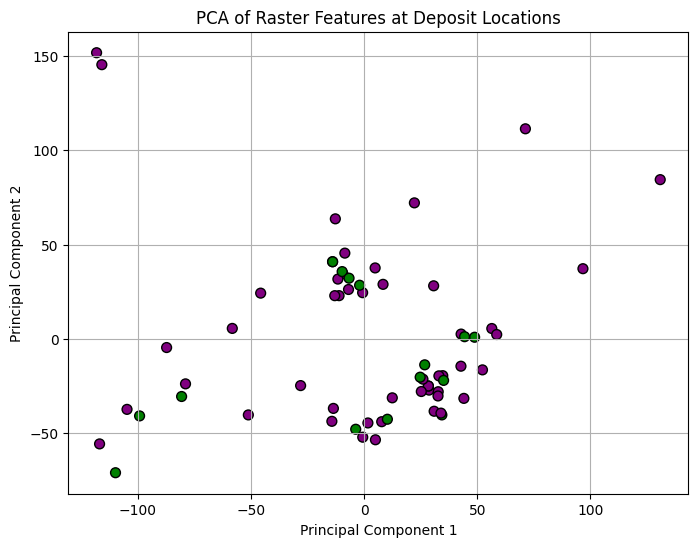

In [20]:
# Plotting the PCA results
# Create a condition to highlight certain points
colors = ['green' if value == 'RS' else 'purple' for value in final_df['COMMOD_C2']]



plt.figure(figsize=(8, 6))
plt.scatter(final_df['PC4'], final_df['PC5'], c=colors, s=50, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Raster Features at Deposit Locations')
plt.grid(True)
plt.show()


#### Kmeans

Before applied kmeans I would like to experiment with some labeling 

labeling

In [40]:
import numpy as np

final_df['label_1'] = np.where(
    # Condition for high confidence (hc): either COMMOD_C1 or COMMOD_C2 has 'RS'
    (final_df['COMMOD_C1'] == 'RS') | (final_df['COMMOD_C2'] == 'RS'),
    'mineralized_hc',  # Assign 'mineralized_hc' if the condition is met
    # Otherwise, check for low confidence (lc) or no mineralized
    np.where(
        # Condition for low confidence (lc): COMMOD_C3 has 'RS'
        final_df['COMMOD_C3'] == 'RS',
        'mineralized_lc',  # Assign 'mineralized_lc' if this condition is met
        'no_mineralized'  # Assign 'no_mineralized' if none of the conditions are met
    )
)

final_df.iloc[:,7:]

,- GRAV - 1st Vertical Derivative_float,- GRAV - Gravity Anomalies_float,- GRAV - Horizontal Gradient_float,- GRAV - Isostatic Residual_float,- 250m - RAD - Potassium K - 2012 - Geotif_float,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif,datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif,label_1
0,199.0,0.0,248.0,167.0,21.412943,229.920990,142.107132,no_mineralized
1,244.0,15.0,159.0,248.0,255.000000,2.997955,22.280083,no_mineralized
2,6.0,0.0,239.0,228.0,255.000000,241.514847,242.756836,mineralized_lc
3,8.0,0.0,172.0,231.0,255.000000,230.572937,232.104263,mineralized_lc
4,247.0,0.0,166.0,245.0,255.000000,237.824356,240.413406,mineralized_lc
...,...,...,...,...,...,...,...,...
60,0.0,0.0,207.0,166.0,255.000000,223.456757,224.088486,mineralized_lc
61,0.0,0.0,194.0,166.0,255.000000,215.194061,212.431625,mineralized_hc
62,210.0,0.0,248.0,178.0,255.000000,154.679199,0.000000,mineralized_hc
63,187.0,0.0,242.0,172.0,255.000000,197.564865,18.362078,mineralized_hc


before amply kmeans we need to scale everything

In [41]:
final_df.columns

Index(['COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1', 'rock_class',
       'belt', 'geometry', '- GRAV - 1st Vertical Derivative_float',
       '- GRAV - Gravity Anomalies_float',
       '- GRAV - Horizontal Gradient_float',
       '- GRAV - Isostatic Residual_float',
       '- 250m - RAD - Potassium K - 2012 - Geotif_float',
       'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif',
       'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif',
       'label_1'],
      dtype='object')

In [42]:
from sklearn.preprocessing import StandardScaler

# Let's assume these are your categorical and numerical
categorical = ['COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1', 'rock_class','belt','label_1']  # Categorical columns
numerical = ['- GRAV - Gravity Anomalies_float',
       '- GRAV - Horizontal Gradient_float',
       '- GRAV - Isostatic Residual_float',
       '- 250m - RAD - Potassium K - 2012 - Geotif_float',
       'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif',
       'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif']  # PCA components

# Apply one-hot encoding to categorical columns
categorical_encoded = pd.get_dummies(final_df[categorical])

# Combine numerical and categorical encoded columns
combined_data = pd.concat([final_df[numerical], categorical_encoded], axis=1)

# Step to scale the combined data
scaler = StandardScaler()
combined_data_scaled = scaler.fit_transform(combined_data)  # Scaled feature set


KeyError: "['datasets\\raster\\x07ligned\\x07ligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif', 'datasets\\raster\\x07ligned\\x07ligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif'] not in index"

kmenas

c:\Users\fdeltoro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fdeltoro\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fdeltoro\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


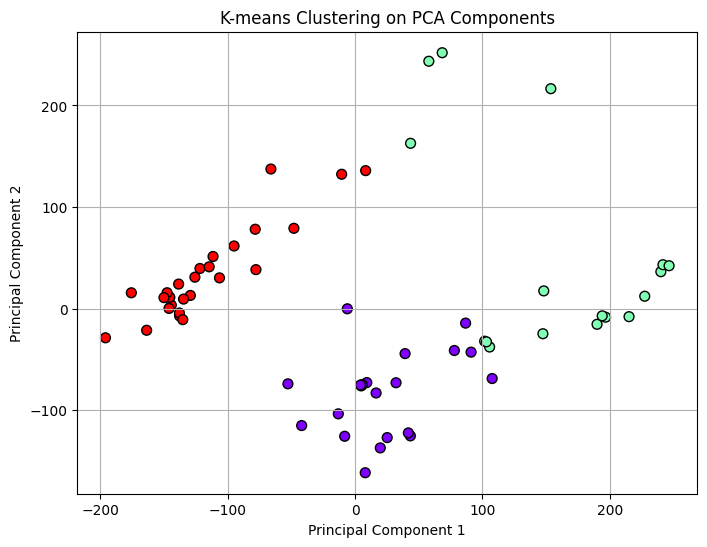

In [23]:
from sklearn.cluster import KMeans

# Aplicar K-means con 3 clusters (por ejemplo)
kmeans = KMeans(n_clusters=3, random_state=42)
final_df['Cluster'] = kmeans.fit_predict(final_df[pca_columns])

# Graficar PC1 vs PC2, coloreando por cluster
plt.figure(figsize=(8, 6))
plt.scatter(final_df['PC1'], final_df['PC2'], c=final_df['Cluster'], cmap='rainbow', s=50, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on PCA Components')
plt.grid(True)
plt.show()


In [25]:
final_df.columns

Index(['STATUS_D', 'COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1',
       'rock_class', 'strat_unit', 'rock_type', 'age_max', 'age_min', 'belt',
       'geometry', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'label_1', 'Cluster'],
      dtype='object')

compareing kmeans and my label

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming you've already run K-means and have the K-means labels in deposits_all['kmeans_label']
# Also assuming deposits_all['label_1'] holds your domain-driven labels ('mineralized_hc', 'mineralized_lc', 'no_mineralized')

# Step 1: Reduce the data to 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(combined_data_scaled)  # Assuming combined_data_scaled is your scaled feature set

# Step 2: Add PCA components to the DataFrame for plotting
deposits_all['PCA1'] = pca_data[:, 0]
deposits_all['PCA2'] = pca_data[:, 1]

# Step 3: Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Step 4: Plot K-means clusters
sns.scatterplot(
    x='PCA1', y='PCA2', hue='kmeans_label', 
    data=deposits_all, ax=axes[0], palette='viridis', s=100, edgecolor='k'
)
axes[0].set_title('K-means Clusters')

# Step 5: Plot your domain labels
sns.scatterplot(
    x='PCA1', y='PCA2', hue='label_1', 
    data=deposits_all, ax=axes[1], palette='coolwarm', s=100, edgecolor='k'
)
axes[1].set_title('Domain Knowledge Labels')

# Step 6: Final adjustments
for ax in axes:
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()



In [2]:
import os
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_deposits_with_pca(raster_paths, deposits_gdf, num_pca_components):
    """
    Function to extract raster values at deposit points, 
    apply PCA, and visualize results.

    Parameters:
    raster_paths (list): List of paths to raster files.
    deposits_gdf (GeoDataFrame): GeoDataFrame containing deposit points.
    num_pca_components (int): Number of principal components for PCA.
    
    Returns:
    final_df (DataFrame): DataFrame with deposit information and PCA results.
    explained_variance (list): List of variance ratios explained by each component.
    loadings_df (DataFrame): DataFrame of PCA loadings for each raster.
    """
    
    # Filter deposits GeoDataFrame as needed before passing to the function
    deposits = deposits_gdf
    
    # Initialize an array to store raster values at each deposit point
    features = np.zeros((len(deposits), len(raster_paths)))
    
    # Extract raster values at deposit locations
    for i, raster_path in enumerate(raster_paths):
        with rasterio.open(raster_path) as src:
            # Extract raster values at deposit points using coordinates (x, y)
            raster_values = [x[0] for x in src.sample([(point.x, point.y) for point in deposits.geometry])]
            features[:, i] = raster_values
    
    # Convert the feature matrix into a DataFrame for further analysis
    features_df = pd.DataFrame(data=features, columns=[os.path.basename(raster_path) for raster_path in raster_paths])
    
    # Apply PCA on the extracted raster values
    pca = PCA(n_components=num_pca_components)
    principal_components = pca.fit_transform(features)
    
    # Create a DataFrame for the PCA results
    pca_columns = [f'PC{i+1}' for i in range(num_pca_components)]
    pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)
    
    # Combine the PCA results with the deposit information
    final_df = pd.concat([deposits.reset_index(drop=True), pca_df], axis=1)
    
    # Get PCA loadings (the importance of each raster in the principal components)
    loadings = pca.components_
    loadings_df = pd.DataFrame(data=loadings, columns=features_df.columns, index=pca_columns)
    
    # Plot a heatmap to visualize PCA loadings
    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('PCA Loadings Heatmap')
    plt.show()
    
    # Get the explained variance ratio for each component
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by each component: {explained_variance}")
    print(f"Total explained variance: {sum(explained_variance)*100:.2f}%")
    
    return final_df, explained_variance, loadings_df


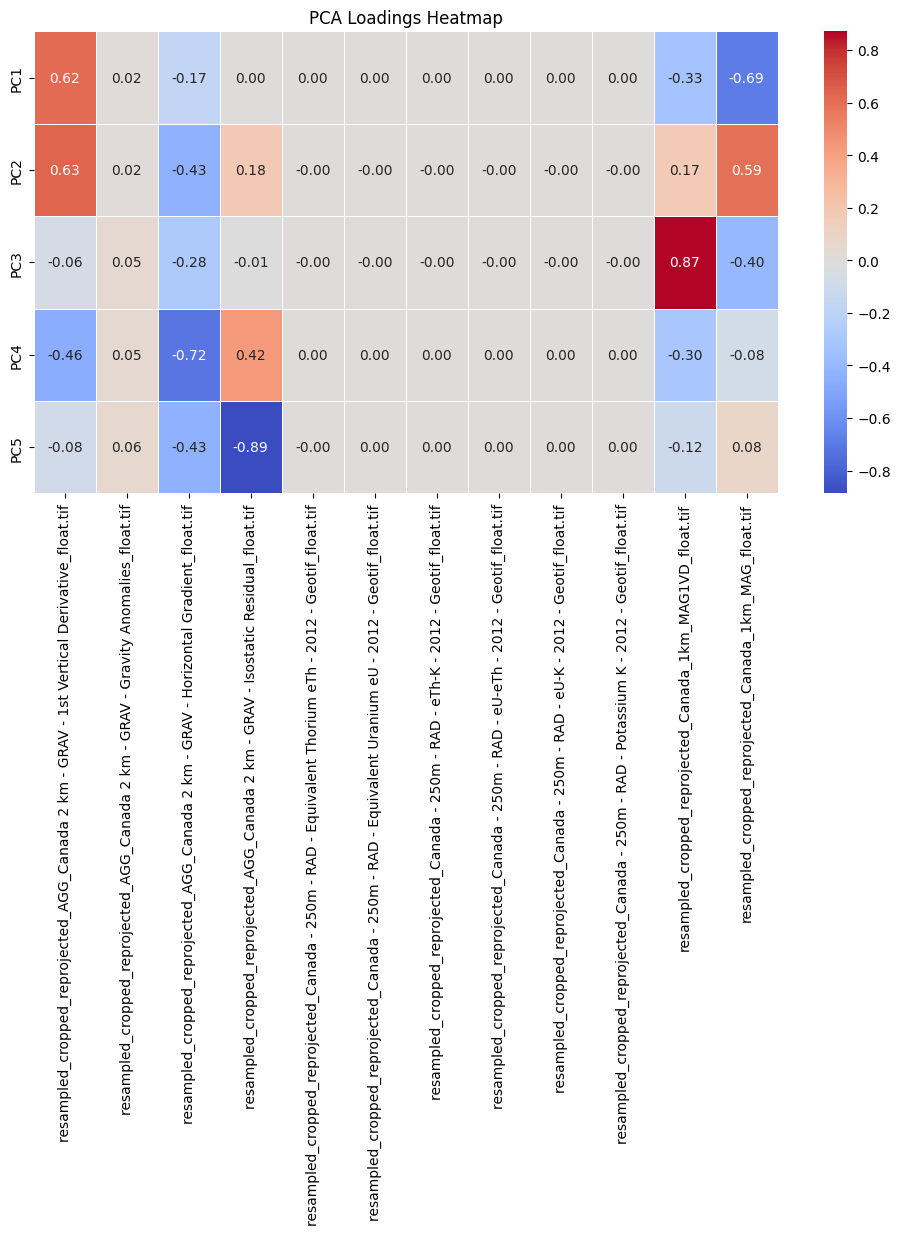

Explained variance by each component: [0.5540469  0.19905502 0.1227313  0.09161054 0.03241375]
Total explained variance: 99.99%


In [3]:

raster_paths = [os.path.join(r'datasets\raster\resampled', f) for f in os.listdir(r'datasets\raster\resampled') if f.lower().endswith('.tif')]

# You can filter the deposits_gdf before calling the function
deposits_gdf = gpd.read_file(r"datasets\shp\cmBC.shp")
filtered_deposits_gdf = deposits_gdf[(deposits_gdf['COMMOD_C1'] == 'RS') | (deposits_gdf['COMMOD_C2'] == 'RS')]

num_pca_components = 5

# Call the function with the filtered GeoDataFrame
final_df, explained_variance, loadings_df = analyze_deposits_with_pca(raster_paths, filtered_deposits_gdf, num_pca_components)

In [38]:
deposits.columns

Index(['STATUS_D', 'COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1',
       'rock_class', 'strat_unit', 'rock_type', 'age_max', 'age_min', 'belt',
       'geometry'],
      dtype='object')

In [66]:
deposits[deposits['DEPTYPE_D1'].isna()]

,STATUS_D,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,rock_class,strat_unit,rock_type,age_max,age_min,belt,geometry
17,Showing,GT,RS,None,None,metamorphic rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Late Devonian,Late Permian,Intermontane,POINT (1531762.801 688171.165)
19,Showing,RS,TH,UR,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (1554227.408 678377.172)
38,Showing,RS,YR,NB,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (1671122.954 727332.681)
47,Showing,CU,AU,RS,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (1180158.942 542329.248)
49,Showing,NB,ZR,RS,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (1275822.434 1052435.580)
50,Showing,NB,SR,RS,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (1274516.204 1053475.240)
64,Showing,RS,YR,None,None,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,POINT (912433.048 1526060.694)


In [57]:
deposits.columns

Index(['STATUS_D', 'COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1',
       'rock_class', 'strat_unit', 'rock_type', 'age_max', 'age_min', 'belt',
       'geometry'],
      dtype='object')